## Looking at the putative TSS bidirectionals (like alternative start sites)

In [2]:
library(data.table)
library(ggplot2)

## 1. Get overlaps of bidirectionals with 600bp TSS region (300bp upstream & downstream from TSS)

```
#!bin/bash

# FOR INITIAL ANALYSIS TO FILTER
# files for filtered bidirectionals & TSS regions
FILT_BID="../data/processed_annotations/hg38_master_qc_gc_len_posneg_gene_filt_uniqueid.bed"
TSS_BED="../data/processed_annotations/hg38_refseq_prim_chrom_transcripts_600bpwinTSS.bed"


# echo "Getting intersections of qc1/2 filtered bidirectionals with promoter regions"
bedtools intersect -a $TSS_BED -b $FILT_BID -f 0.05 -wo > overlaps_all_proms_bids_qc1_2_posneg_gene_filt.bed

# FOR FINAL TSS
# files for filtered bidirectionals & TSS regions
FILT_BID="../data/processed_annotations/hg38_master_qc_gc_len_posneg_gene_filt_divconv_uniqueid_08-14-23.bed"

# echo "Getting intersections of fully filtered bidirectionals with TSS regions"
bedtools intersect -a $TSS_BED -b $FILT_BID -f 0.05 -wo > overlaps_all_filt_bids_full_gene_filt.bed
```


In [106]:
# read in putative TSS overlaps
#overlaps_filt <- fread("overlaps_all_proms_bids_qc1_2_posneg_gene_filt.bed")
overlaps_filt <- fread("overlaps_all_filt_bids_full_gene_filt.bed")
dim(overlaps_filt)
overlaps_filt[1:2,]
colnames(overlaps_filt) <- c("Gene_chr", "Gene_Start", "Gene_Stop", "TranscriptID", 
                       "Gene_score", "strand", "GeneID", "Gene_Length", 
                       "Bid_chr", "Bid_Start", "Bid_Stop", 
                           "BidID",  
                       "overlap")
# colnames(overlaps_filt) <- c("Gene_chr", "Gene_Start", "Gene_Stop", "TranscriptID", 
#                        "Gene_score", "strand", "GeneID", "Gene_Length", 
#                        "Bid_chr", "Bid_Start", "Bid_Stop", 
#                             'source', "BidID",  
#                        "overlap")
overlaps_filt[1:2,]

[1] 77155    13

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17003,17329,chr1-17003-17329-dreg,193
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,17621,chr1-17453-17621-tfit,168


Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,Bid_Stop,BidID,overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17003,17329,chr1-17003-17329-dreg,193
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,17621,chr1-17453-17621-tfit,168


## Look at basic stats

In [107]:
# see how many bids occur per transcript
transcript_freq <- data.frame(table(overlaps_filt$TranscriptID))
dim(transcript_freq[transcript_freq$Freq == 3,])
# see how many TSS regions a bid overlaps with 
bid_freq <- data.frame(table(overlaps_filt$BidID))
p1 <- ggplot(transcript_freq, aes(x=Freq)) + geom_histogram(binwidth=1) + 
ggtitle("GC/Len filt: Num Bids per TSS region")+ theme_bw(base_size=13)

p2 <- ggplot(bid_freq, aes(x=Freq)) + geom_histogram(binwidth=1) + 
ggtitle(paste0("GC/Len filt: Num TSS regions per Bidirectional (Median=",median(bid_freq$Freq), 
               ", Mean=", round(mean(bid_freq$Freq),2),")")) + theme_bw(base_size=13)
p3 <- ggplot(bid_freq[bid_freq$Freq > 25,], aes(x=Freq)) + geom_histogram(binwidth=1) + 
ggtitle(paste0(">25 GC/Len filt: Num TSS regions per Bidirectional (Median=",median(bid_freq[bid_freq$Freq > 25,]$Freq), 
               ", Mean=", round(mean(bid_freq[bid_freq$Freq > 25,]$Freq),2),")"))+ theme_bw(base_size=13)
bid_freq <- data.frame(table(bid_freq[,2]))

library(cowplot)


[1] 343   2

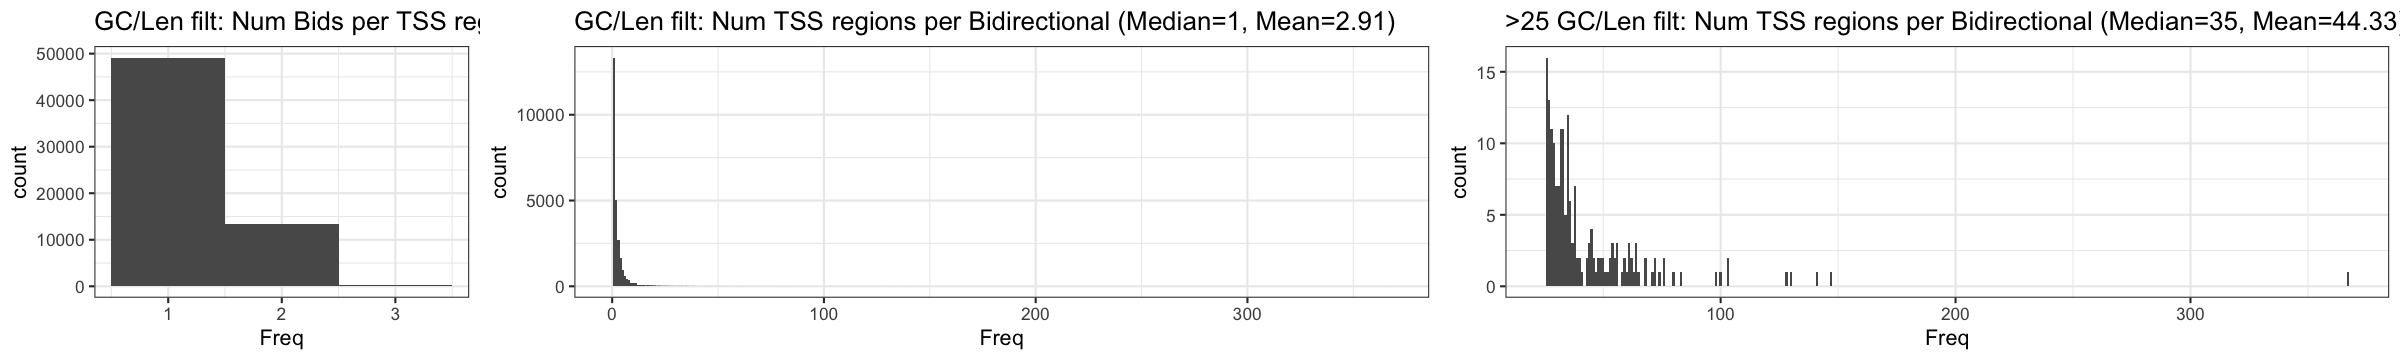

In [108]:
options(repr.plot.height = 3, repr.plot.width = 20)
plot_grid(p1, p2, p3, nrow=1, rel_widths=c(0.5,1,1))

In [109]:
# add a unique id
overlaps_filt$unique_id <- paste0(overlaps_filt$TranscriptID, ":", overlaps_filt$BidID)
# get the fraction of the TSS region overlapped
overlaps_filt$Frac_TSS_overlap <- round(overlaps_filt$overlap/600,5)
# get the fraction of the Bid overlapped
overlaps_filt$Bid_Length <- overlaps_filt$Bid_Stop - overlaps_filt$Bid_Start + 1
overlaps_filt$Frac_Bid_overlap <- round(overlaps_filt$overlap/overlaps_filt$Bid_Length,5)
overlaps_filt[1:2,]

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,Bid_Stop,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17003,17329,chr1-17003-17329-dreg,193,MIR6859-1:NR_106918.1:chr1-17003-17329-dreg,0.32167,327,0.59021
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,17621,chr1-17453-17621-tfit,168,MIR6859-1:NR_106918.1:chr1-17453-17621-tfit,0.28000,169,0.99408


In [110]:
dim(overlaps_filt)
length(unique(overlaps_filt$TranscriptID))
length(unique(overlaps_filt$BidID))

[1] 77155    17

[1] 62990

[1] 26484

## For repeating transcripts, get the most likely candidate bidirectional according to 3 methods
1. Bidirectional most covered by TSS region
2. Bidirectional that covers most of TSS region
3. Bidirectional w/ mu closest to TSS

In [111]:

# for each transcript with MORE THAN ONE coordinating promoter bidirectional, get one most overlapping
dup_transcripts <- overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)]
length(dup_transcripts)
# WITH Top BID overlap
keep_list_filt <- c()
for (transcript in dup_transcripts) {
    # get all overlaps
    filtered <- overlaps_filt[overlaps_filt$TranscriptID == transcript,]
    # order by fraction of TSS region overlapping
    filtered <- filtered[order(-filtered$Frac_Bid_overlap),]
    # add unique id of first
    keep_list_filt <- c(keep_list_filt, filtered$unique_id[1])
    }
# WITH Top TSS overlap
keep_list_filtTSS <- c()
for (transcript in dup_transcripts) {
    # get all overlaps
    filtered <- overlaps_filt[overlaps_filt$TranscriptID == transcript,]
    # order by fraction of TSS region overlapping
    filtered <- filtered[order(-filtered$Frac_TSS_overlap),]
    # add unique id of first
    keep_list_filtTSS <- c(keep_list_filtTSS, filtered$unique_id[1])
    }

# Get distance from mu
overlaps_filt$mu <- (overlaps_filt$Bid_Start + overlaps_filt$Bid_Stop)/2
overlaps_filt$TSS <- (overlaps_filt$Gene_Start + overlaps_filt$Gene_Stop)/2
overlaps_filt$MUDIFF <- abs(overlaps_filt$mu-overlaps_filt$TSS)
overlaps_filt[1:2,]
# WITH Top Mu clsoest
keep_list_filtmu <- c()
for (transcript in dup_transcripts) {
    # get all overlaps
    filtered <- overlaps_filt[overlaps_filt$TranscriptID == transcript,]
    # order by fraction of TSS region overlapping
    filtered <- filtered[order(filtered$MUDIFF),]
    # add unique id of first
    keep_list_filtmu <- c(keep_list_filtmu, filtered$unique_id[1])
    }

[1] 14165

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,Bid_Stop,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17003,17329,chr1-17003-17329-dreg,193,MIR6859-1:NR_106918.1:chr1-17003-17329-dreg,0.32167,327,0.59021,17166,17436,270
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,17621,chr1-17453-17621-tfit,168,MIR6859-1:NR_106918.1:chr1-17453-17621-tfit,0.28000,169,0.99408,17537,17436,101


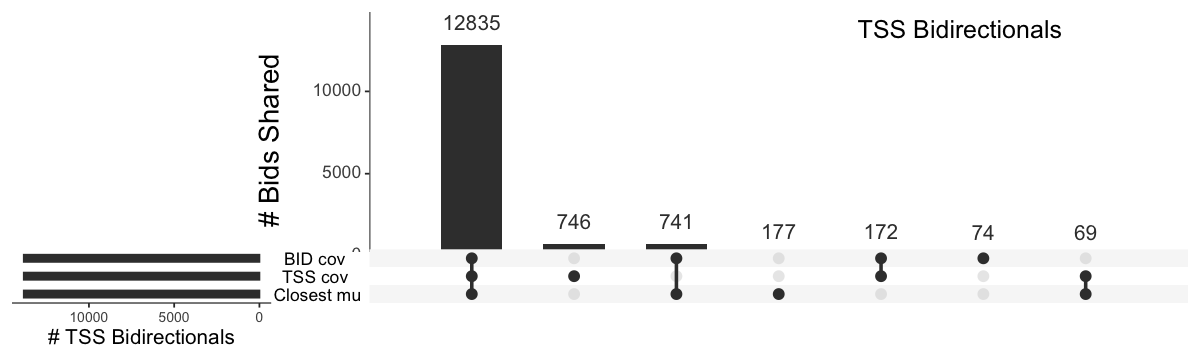

In [112]:
options(repr.plot.height = 3, repr.plot.width =10 )
library(UpSetR)
library(grid)
ListInput <- list("BID cov" = keep_list_filt, 
                  "TSS cov" = keep_list_filtTSS, 
                  "Closest mu" = keep_list_filtmu)
upset(fromList(ListInput), nsets=3,
      order.by = "freq", keep.order=TRUE, sets.x.label= "# TSS Bidirectionals", 
      point.size=3, line.size=1, 
      mainbar.y.label = "# Bids Shared", text.scale = c(2, 1.5, 1.5, 1.2, 1.5, 2))
grid.text("TSS Bidirectionals",x = 0.8, y=0.92, gp=gpar(fontsize=15))

In [114]:
# how many of the duplicated genes are assigned to a non-long isoform and therefore would have implications in the gene-centric stats
# read in long isoforms
long <- fread("../data/processed_annotations/hg38_refseq_prim_chrom_longisof_transcripts.bed")
long[1:2,]
# how many of the duplicated genes are NOT longest isoforms
length(overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)])
length(setdiff(overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)],long$V4))

V1,V2,V3,V4,V5,V6,V7,V8
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,DDX11L1,2536
chr1,14361,29370,WASH7P:NR_024540.1,.,-,WASH7P,15009


[1] 14165

[1] 10305

In [125]:
# check lengths are proper
length(keep_list_filt)

print("Filt")
non_dup <- overlaps_filt[!overlaps_filt$TranscriptID %in% overlaps_filt$TranscriptID[duplicated(overlaps_filt$TranscriptID)],]
dim(non_dup)
dup <- overlaps_filt[overlaps_filt$unique_id %in% keep_list_filtmu,]
dim(dup)
tss_filt <- rbind(dup, non_dup)
dim(tss_filt)
                        

[1] 14165

[1] "Filt"


[1] 49168    20

[1] 13822    20

[1] 62990    20

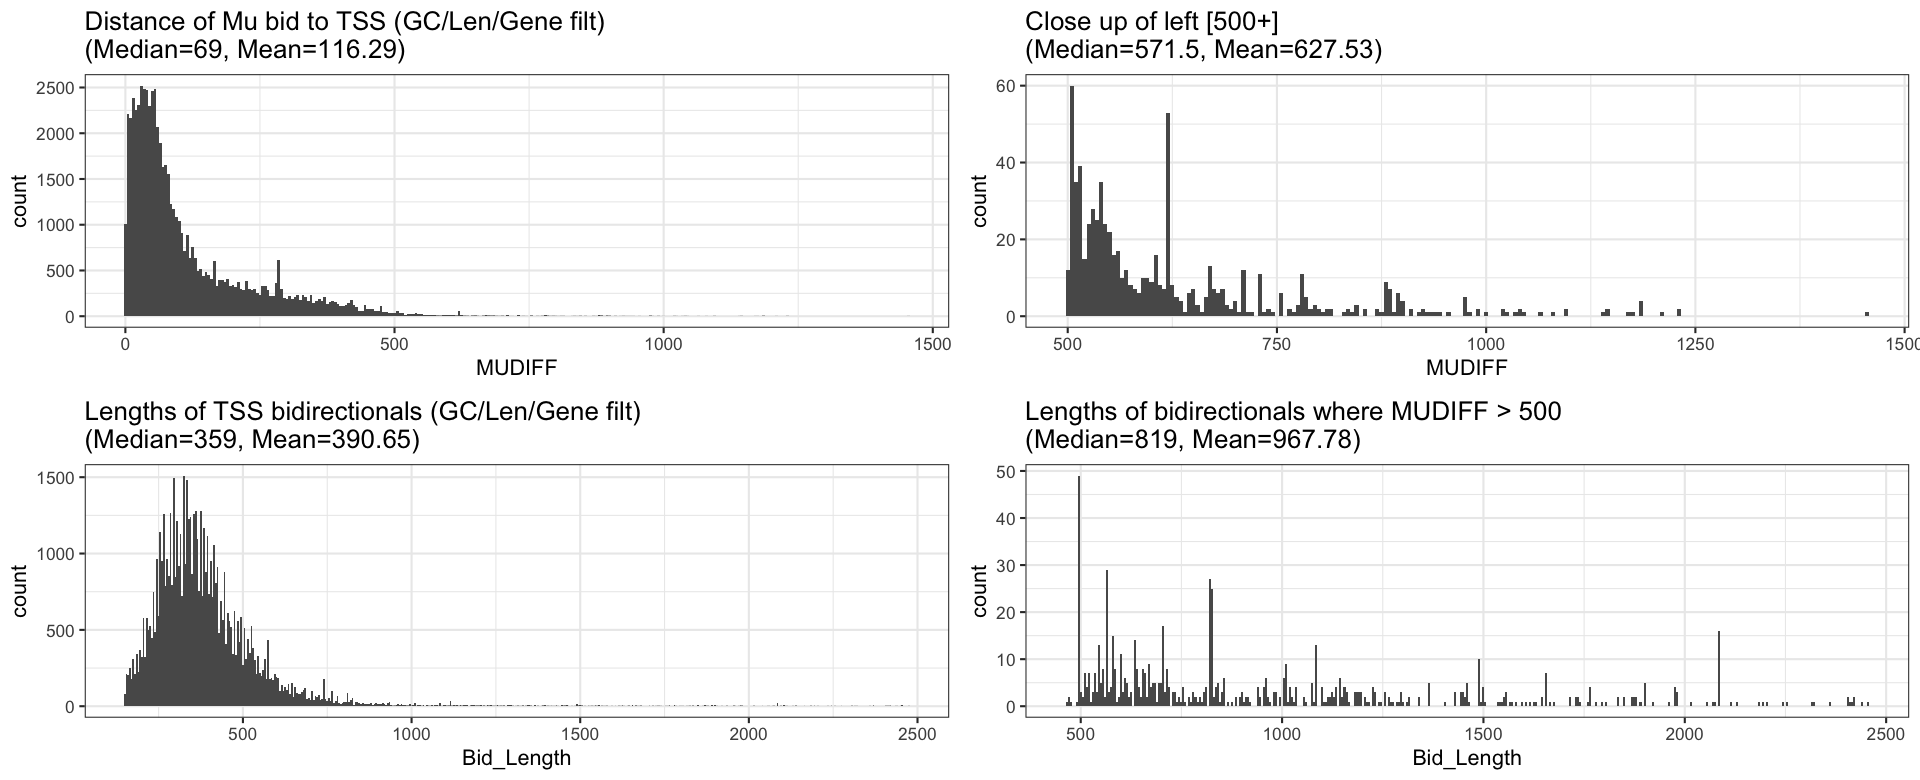

In [116]:
# graph the final distances to mu
options(repr.plot.height = 6.5, repr.plot.width = 16)
p1 <- ggplot(tss_filt, aes(x=MUDIFF)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Distance of Mu bid to TSS (GC/Len/Gene filt) \n(Median=",median(tss_filt$MUDIFF), 
               ", Mean=", round(mean(tss_filt$MUDIFF),2),")")) + theme_bw(base_size=13)
p2 <- ggplot(tss_filt[tss_filt$MUDIFF > 500], aes(x=MUDIFF)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Close up of left [500+] \n(Median=",median(tss_filt[tss_filt$MUDIFF > 500]$MUDIFF), 
               ", Mean=", round(mean(tss_filt[tss_filt$MUDIFF > 500]$MUDIFF),2),")")) + theme_bw(base_size=13)
p3 <- ggplot(tss_filt, aes(x=Bid_Length)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Lengths of TSS bidirectionals (GC/Len/Gene filt) \n(Median=",median(tss_filt$Bid_Length), 
               ", Mean=", round(mean(tss_filt$Bid_Length),2),")")) + theme_bw(base_size=13)
p4 <- ggplot(tss_filt[tss_filt$MUDIFF > 500], aes(x=Bid_Length)) + geom_histogram(binwidth=5) + 
ggtitle(paste0("Lengths of bidirectionals where MUDIFF > 500 \n(Median=",median(tss_filt[tss_filt$MUDIFF > 500]$Bid_Length), 
               ", Mean=", round(mean(tss_filt[tss_filt$MUDIFF > 500]$Bid_Length),2),")")) + theme_bw(base_size=13)
plot_grid(p1, p2, p3, p4, nrow=2)

The distance of mu of the bidirectional from the TSS can range with distances as high as above 1kb. This can be explained by the bidirectionals being substantially long as seen in the bottom right. Notably, these bidirectionals still were closest to mu.

In [117]:
# ccheck out those that are above 1000
test <- tss_filt[tss_filt$MUDIFF > 500]
dim(test)
length(intersect(long$V4, test$TranscriptID))
dim(tss_filt[tss_filt$MUDIFF > 1000])
length(intersect(long$V4, tss_filt[tss_filt$MUDIFF > 1000]$TranscriptID))
#tss_filt[tss_filt$MUDIFF > 1000]

[1] 742  20

[1] 320

[1] 24 20

[1] 19

In [124]:
dim(tss_filt)
long[1:2,]
tss_filt[1:2,]
length(intersect(tss_filt$TranscriptID, long$V4))
print("Number of Total Isoforms with a TSS")
length(intersect(tss_filt$TranscriptID, overlaps_filt$TranscriptID))
length(unique(tss_filt$TranscriptID))
length(unique(tss_filt$TranscriptID))/80565
print("Number of GENES with TSS")
length(unique(tss_filt$GeneID))
length(unique(tss_filt$GeneID))/nrow(long)

[1] 62990    10

V1,V2,V3,V4,V5,V6,V7,V8
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,DDX11L1,2536
chr1,14361,29370,WASH7P:NR_024540.1,.,-,WASH7P,15009


chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,MIR6859-1:NR_106918.1,-,MIR6859-1,chr1-17453-17621-tfit,0.28000,0.99408,17537,17436,101
chr1,LOC127239154:NR_182074.1,-,LOC127239154,chr1-297077-297529-dreg,0.54167,0.71744,297303,297504,201


[1] 18231

[1] "Number of Total Isoforms with a TSS"


[1] 62990

[1] 62990

[1] 0.7818532

[1] "Number of GENES with TSS"


[1] 19301

[1] 0.668109

In [119]:
nrow(long)
length(intersect(tss_filt$TranscriptID, long$V4))/nrow(long)

[1] 28889

[1] 0.6310706

63% of the Long isoforms have a TSS assigned to them. 

## Save TSS bidirectionals used

In [134]:
tss_filt[1:2,]
colnames(tss_filt)
tss_filt <- tss_filt[,c("Gene_chr", "TranscriptID", "strand", "GeneID", "BidID", "Frac_TSS_overlap", "Frac_Bid_overlap", "mu", "TSS", "MUDIFF")]
tss_filt[1:2,]

Gene_chr,Gene_Start,Gene_Stop,TranscriptID,Gene_score,strand,GeneID,Gene_Length,Bid_chr,Bid_Start,⋯,BidID,overlap,unique_id,Frac_TSS_overlap,Bid_Length,Frac_Bid_overlap,mu,TSS,MUDIFF,BidID2
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,⋯,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr1,17136,17736,MIR6859-1:NR_106918.1,.,-,MIR6859-1,68,chr1,17453,⋯,chr1-17453-17621-tfit,168,MIR6859-1:NR_106918.1:chr1-17453-17621-tfit,0.28000,169,0.99408,17537,17436,101,chr1-17453-17621
chr1,297204,297804,LOC127239154:NR_182074.1,.,-,LOC127239154,34786,chr1,297077,⋯,chr1-297077-297529-dreg,325,LOC127239154:NR_182074.1:chr1-297077-297529-dreg,0.54167,453,0.71744,297303,297504,201,chr1-297077-297529


[1] "Gene_chr"         "Gene_Start"       "Gene_Stop"        "TranscriptID"    
 [5] "Gene_score"       "strand"           "GeneID"           "Gene_Length"     
 [9] "Bid_chr"          "Bid_Start"        "Bid_Stop"         "BidID"           
[13] "overlap"          "unique_id"        "Frac_TSS_overlap" "Bid_Length"      
[17] "Frac_Bid_overlap" "mu"               "TSS"              "MUDIFF"          
[21] "BidID2"

Gene_chr,TranscriptID,strand,GeneID,BidID,Frac_TSS_overlap,Frac_Bid_overlap,mu,TSS,MUDIFF
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,MIR6859-1:NR_106918.1,-,MIR6859-1,chr1-17453-17621-tfit,0.28000,0.99408,17537,17436,101
chr1,LOC127239154:NR_182074.1,-,LOC127239154,chr1-297077-297529-dreg,0.54167,0.71744,297303,297504,201


In [135]:
colnames(tss_filt) <- c("chr", "TranscriptID", "strand", "GeneID", "BidID", "Frac_TSS_overlap", "Frac_Bid_overlap", "mu", "TSS", "MUDIFF")
write.table(tss_filt, "../data/processed_annotations/tss_bids_08-14-23.txt", 
            row.names=FALSE, sep="\t", quote=FALSE)

In [94]:
sessionInfo()

R version 4.3.0 (2023-04-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/hopekirby/miniconda3/envs/r-kernel/lib/libopenblasp-r0.3.23.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Denver
tzcode source: system (macOS)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] UpSetR_1.4.0      cowplot_1.1.1     ggplot2_3.4.2     data.table_1.14.8

loaded via a namespace (and not attached):
 [1] crayon_1.5.2     vctrs_0.6.3      cli_3.6.1        rlang_1.1.1     
 [5] generics_0.1.3   jsonlite_1.8.7   labeling_0.4.2   glue_1.6.2      
 [9] colorspace_2.1-0 plyr_1.8.8       htmltools_0.5.5  IRdisplay_1.1   
[13] gridExtra_2.3    IRkernel_1.3.2   scales_1.2.1     fansi_1.0.4     
[17] evaluate_0.21    munsell_0.5.0    tibble_3.2.1     fastmap_1.1.